##### Download, normalize and split vol cube data into train/test datasets

In [1]:
import sys
sys.path.append('../..')  # to go to the main folder of the whole project

# Download the data
from src.data.vol.get_vol_cube_tenors_strikes_dates import get_vol_cube_tenors_strikes_dates
data, opt_tenors, swap_tenors, strikes, dates = get_vol_cube_tenors_strikes_dates()

# Normalize data
from src.data.vol.normalizer import Normalizer
normalizer = Normalizer()
data_norm = normalizer.normalize(data)

# Split train and test datasets
dataset_split_type = 'temporal_split'
from src.utils.get_train_test_datasets import get_train_test_datasets
data_norm_train, dates_train, data_norm_test, dates_test = get_train_test_datasets(data_norm,
                                                                                   dates,
                                                                                   type=dataset_split_type)

data_train = normalizer.denormalize(data_norm_train)
data_test = normalizer.denormalize(data_norm_test)

##### Load the saved model and its history from the file

In [2]:
from src.utils.load_model_and_history import load_model_and_history

NAME = 'vae_van_leaky_3_128_48_3000ep_bat16_3e-4'
vae, history = load_model_and_history(NAME,
                                      data_type='vol')

c:\Users\alexi\Documents\All\ETH_UZH\MasterThesis\_MT_Vol_cube\code_my\autoencoder_library\venv\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


##### Plot history of train and test losses against the epochs

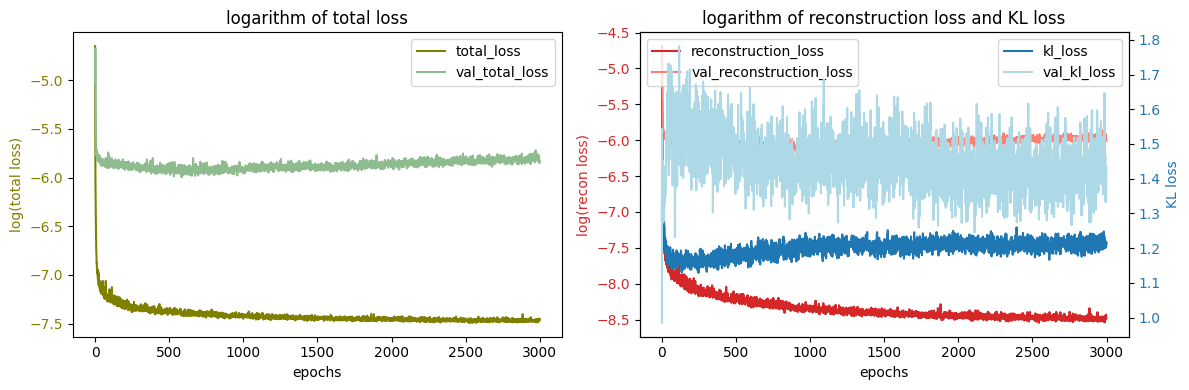

In [3]:
from src.visualization.plot_history_of_losses import plot_history_of_losses
plot_history_of_losses(history,
                       data_type='vol',
                       save_name=NAME)

# Compress

##### Plot 2d latent space values

For each date, based on vol cube test data, we calculate latent space values z0, z1 and z2

The latent space variables (z0, z1, z2) for train dataset look similar to the Gaussian distribution - that's why Kullback-Leibner loss is small

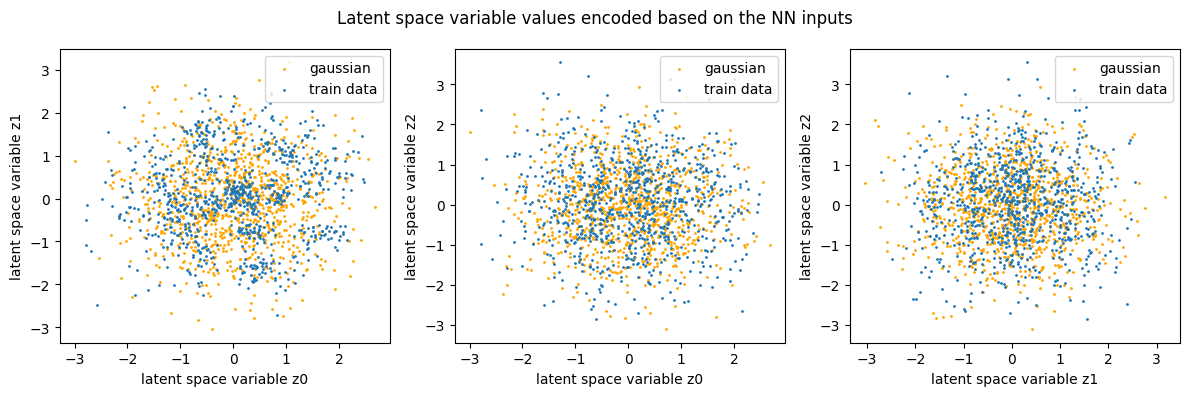

In [4]:
from src.visualization.vol.scatplot_latent_space_3d_values import scatplot_latent_space_3d_values
scatplot_latent_space_3d_values(vae, 
                            label1='gaussian',
                            label2='train data',
                            data2=data_norm_train)

The distribution for latent space variables (z0, z1 and z2) for train and test datasets can be found below. The distributions are NOT similar, so the results of compressing, completing and generating volatility cubes for this model and temporal splitting here are not so good as for random splitting.

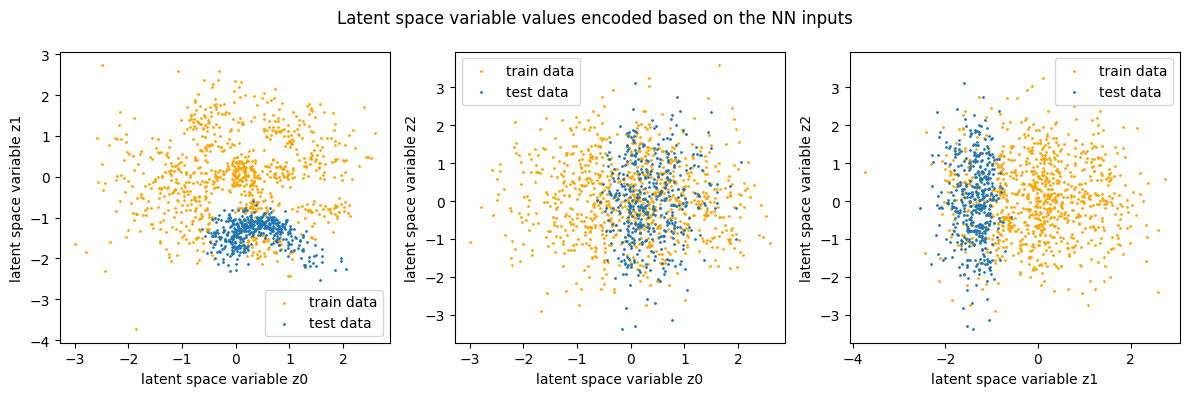

In [5]:
from src.visualization.vol.scatplot_latent_space_3d_values import scatplot_latent_space_3d_values
scatplot_latent_space_3d_values(vae, 
                                label1='train data',
                                data1=data_norm_train,
                                label2='test data',
                                data2=data_norm_test)

##### Error histograms

Error histogram shows the distribution of errors. Each error is the difference between real volatility value and reconstructed volatility value from VAE for a certain data point (with a certain strike, swap tenor and option tenor) in volatility cube and a certain date. Mean (and max) is calculated over all dates and data points in vol cube.

##### Error histograms for train dataset:

Mean error 2.27
Max error 126.74


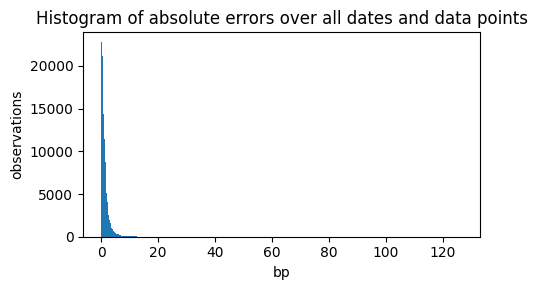

In [6]:
from src.visualization.vol.hist_errors import hist_errors

predictions = normalizer.denormalize(vae.predict(x=data_norm_train, verbose=0))
hist_errors(predictions,
                 data_train,
                 bins=500)

##### Error histograms for test dataset:

Mean error 6.37
Max error 103.61


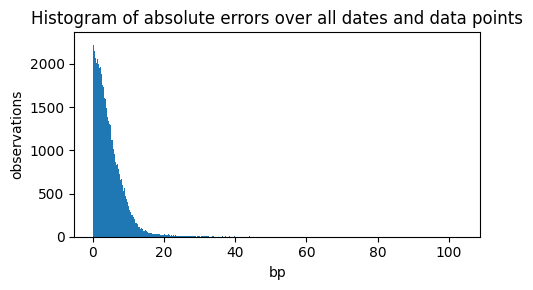

In [7]:
from src.visualization.vol.hist_errors import hist_errors

predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
hist_errors(predictions,
                 data_test,
                 bins=500)

As we can see from the graph above, mean Average error is 1.52bp which is significantly less than bid-ask spread for IR vols.

Max error is more than 40bp which is comparable to the bid-ask spread for large (246bp) vol values.

In [8]:
THRESHOLD = 10 # bp
diffs = abs(predictions - data_test).reshape(-1)
print(f'percentage of errors in test dataset smaller than {THRESHOLD}bp is {(1 - len(diffs[diffs > THRESHOLD]) / len(diffs)) * 100:.1f}%')

percentage of errors in test dataset smaller than 10bp is 91.7%


##### "Predictions vs real data" graphs on the test dataset

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


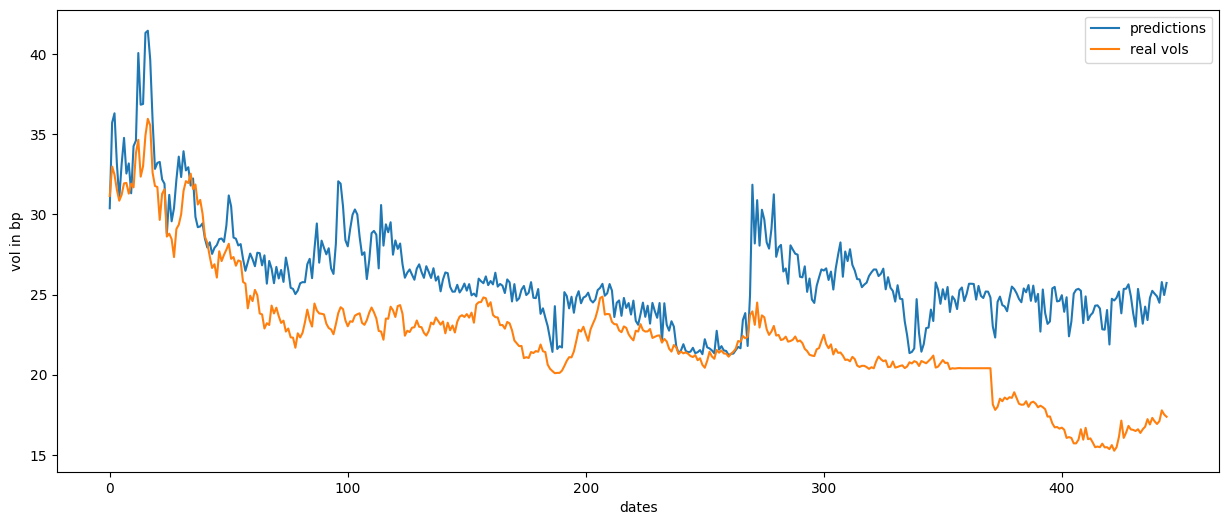

In [9]:
from src.visualization.vol.plot_real_vs_prediction_vols import plot_real_vs_prediction_vols

N1 = 5  # option tenor index (10Y)
N2 = 4  # swap tenor index (10Y)
N3 = 2  # strike index (ATM)

predictions = normalizer.denormalize(vae.predict(x=data_norm_test))
plot_real_vs_prediction_vols(predictions=predictions,
                             real_vols=data_test,
                             indexes=[N1, N2, N3])

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step


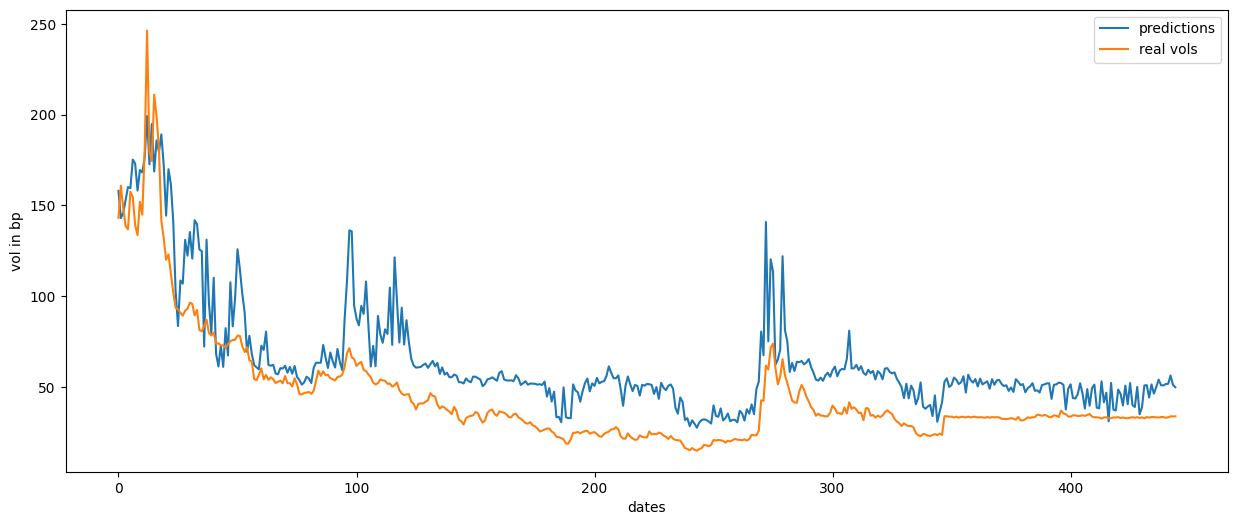

In [10]:
import matplotlib.pyplot as plt
N1 = 0  # option tenor index (1M)
N2 = 0  # swap tenor index (1Y)
N3 = 0  # strike index (ATM-100bp)

predictions = normalizer.denormalize(vae.predict(x=data_norm_test))
plot_real_vs_prediction_vols(predictions=predictions,
                             real_vols=data_test,
                             indexes=[N1, N2, N3])

##### Error grids for different tenors and strikes on the test dataset

For each option tenor, swap tenor and strike, we calculate MEAN error over all dates

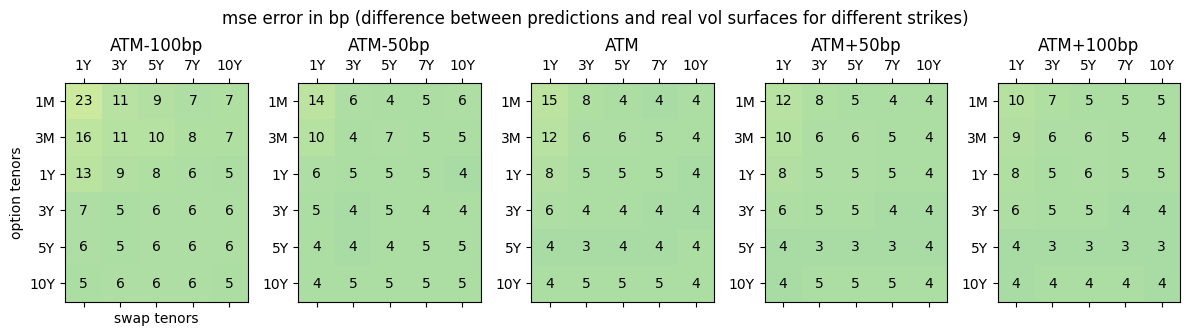

In [11]:
from src.visualization.vol.grids_vol_cube_errors import grids_vol_cube_errors

predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
grids_vol_cube_errors(predictions,
                     data_test,
                     x_labels=swap_tenors,
                     y_labels=opt_tenors,
                     strikes=strikes,
                     error_type='mse'
                     )

For each option tenor, swap tenor and strike, we calculate MAX error over all dates

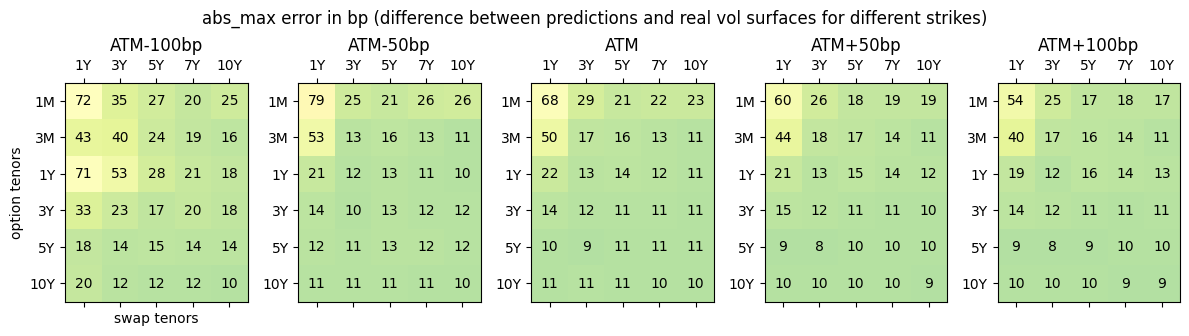

In [12]:
from src.visualization.vol.grids_vol_cube_errors import grids_vol_cube_errors

predictions = normalizer.denormalize(vae.predict(x=data_norm_test, verbose=0))
grids_vol_cube_errors(predictions,
                     data_test,
                     x_labels=swap_tenors,
                     y_labels=opt_tenors,
                     strikes=strikes,
                     error_type='abs_max'
                     )

# Analyze

##### Changing of vol cube data when we change z0, z1 and z2 values

* When latent space variable z0 is large, all vols are large and when z2 is very negative, all vols are small. Also, when z0 is large, we see larger values for short-term vols. So, z0 is responsible for overall level of volatilities and higher short-term vols.

* When latent space variable z1 is large, we see that vol surfaces for different strikes started to differ. So, z1 is responsible for smile.

* Changing z2 does not impact volatility cube structure a lot.

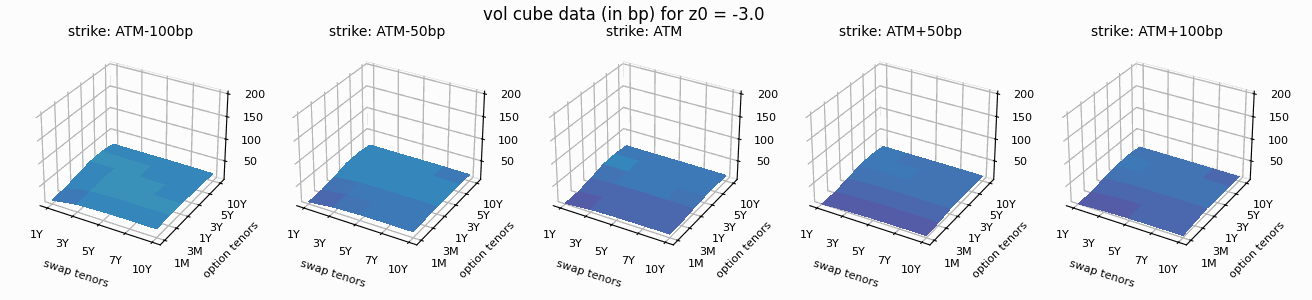

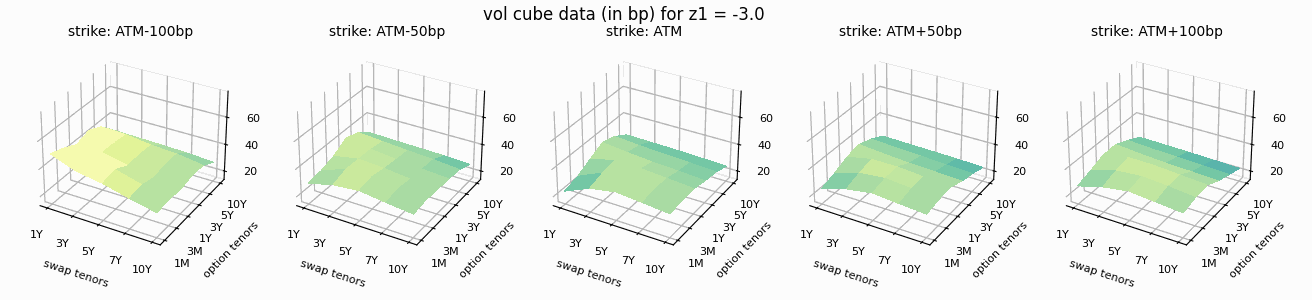

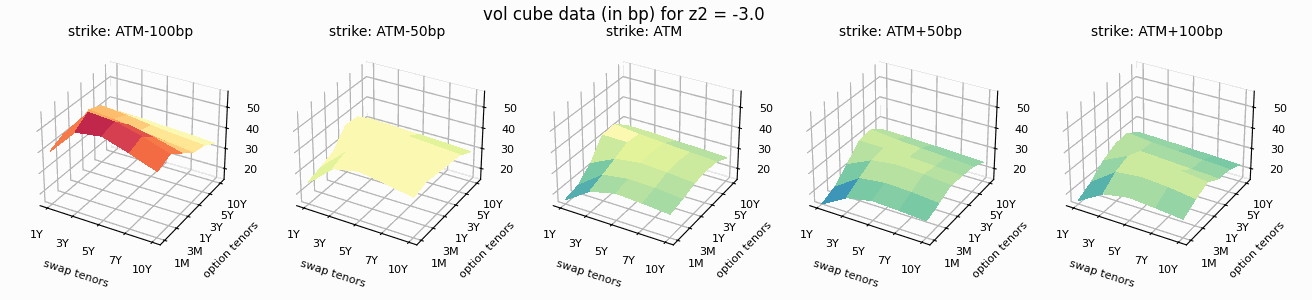

In [13]:
from src.visualization.vol.gif_vol_cube_for_diff_z import gif_vol_cube_for_diff_z

for z_idx in range(vae.latent_space_dim):
    gif_vol_cube_for_diff_z(vae,
                            normalizer,
                            all_z_vals=[0] * vae.latent_space_dim,
                            z_idx=z_idx,
                            x_labels=swap_tenors,
                            y_labels=opt_tenors,
                            strikes=strikes,
                            delete_pngs=True,
                            save_name= NAME + '_diff_z' + str(z_idx)
                            )

# Complete

### Let's assume that ATM vols will be missed for the date with largest vols

##### Create dataset with missed values

In [14]:
# Select index in test dataset for the date with largest vol
if dataset_split_type == 'random_split':
    date_idx = 0   # the date with largest vols that we will investigate     
elif dataset_split_type == 'temporal_split':
    date_idx = 12  # the date with largest vols that we will investigate
# Select the missed strike
missed_strikes = [2]   # 0 is ATM-100bp, 1 is ATM-50bp, 2 is ATM, 3 is ATM+50bp, 4 is ATM+100bp

# Import what value is considered as a missed value
from references.global_parameters import MISSED_VALUE

# Create dataset with missed values
data_test_missed = data_test.copy()
for missed_stk in missed_strikes:
    data_test_missed[date_idx][:, :, missed_stk] = MISSED_VALUE

# Create normalized dataset with missed values
data_norm_test_missed = data_norm_test.copy()
for missed_stk in missed_strikes:
    data_norm_test_missed[date_idx][:, :, missed_stk] = MISSED_VALUE

##### Draw real data grid and real data grid with missed values

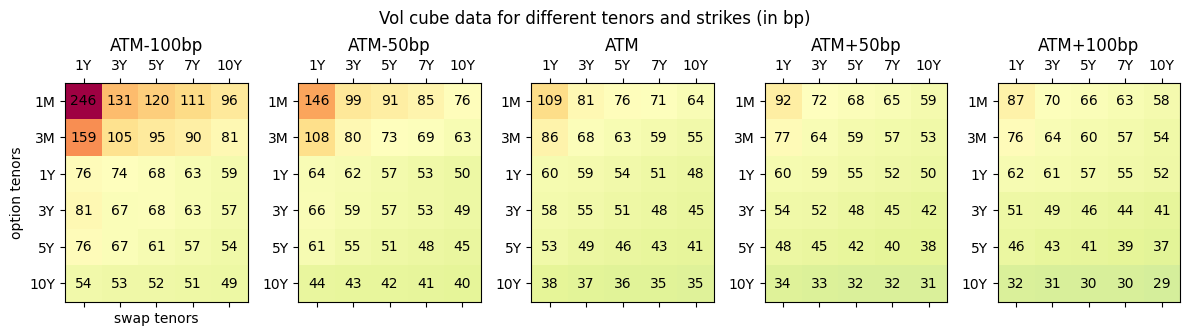

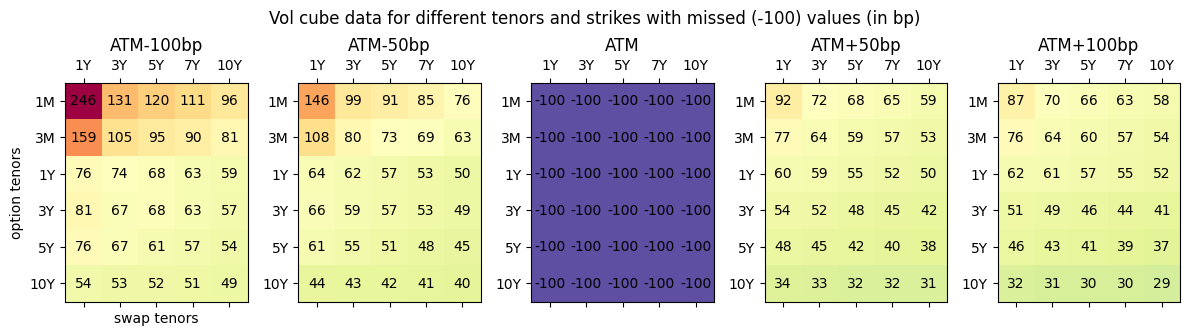

In [15]:
from src.visualization.vol.grids_vol_cube import grids_vol_cube

# Draw real data grid
grids_vol_cube(data=data_test[date_idx],
               x_labels=swap_tenors,
               y_labels=opt_tenors,
               strikes=strikes)

# Draw grid of real data with missed values
grids_vol_cube(data=data_test_missed[date_idx],
               x_labels=swap_tenors,
               y_labels=opt_tenors,
               strikes=strikes)

##### Complete the missed data in vol cube and check errors against real data

In [16]:
from src.utils.vol.find_z_to_complete_vol_cube import find_z_to_complete_vol_cube
z_optimal = find_z_to_complete_vol_cube(vae=vae,
                                        data=data_norm_test_missed[date_idx],
                                        random_attempt_num=5, # number of attempts starting from different random z initial values
                                        random_seed=0,
                                        print_status=True
                                        )

iteration #0
z_initial [5.29215704 1.20047163 2.93621395]
z_optimal [ 2.1092582  -4.21892111  8.08477315]
current mse 0.20069529209394502
best mse 0.20069529209394502
----------------------
iteration #1
z_initial [ 6.7226796   5.60267397 -2.93183364]
z_optimal [ 2.10023724 -4.18381166 11.70383024]
current mse 0.19977391238501013
best mse 0.19977391238501013
----------------------
iteration #2
z_initial [ 2.85026525 -0.45407162 -0.30965656]
z_optimal [ 2.10023724 -4.18381166 11.70383024]
current mse 0.1997739434474075
best mse 0.19977391238501013
----------------------
iteration #3
z_initial [1.23179551 0.43213071 4.36282052]
z_optimal [ 2.10023724 -4.18381166 11.70383024]
current mse 0.1997739447802914
best mse 0.19977391238501013
----------------------
iteration #4
z_initial [2.28311318 0.36502505 1.3315897 ]
z_optimal [ 2.10023724 -4.18381166 11.70383024]
current mse 0.6777390256264055
best mse 0.19977391238501013
----------------------


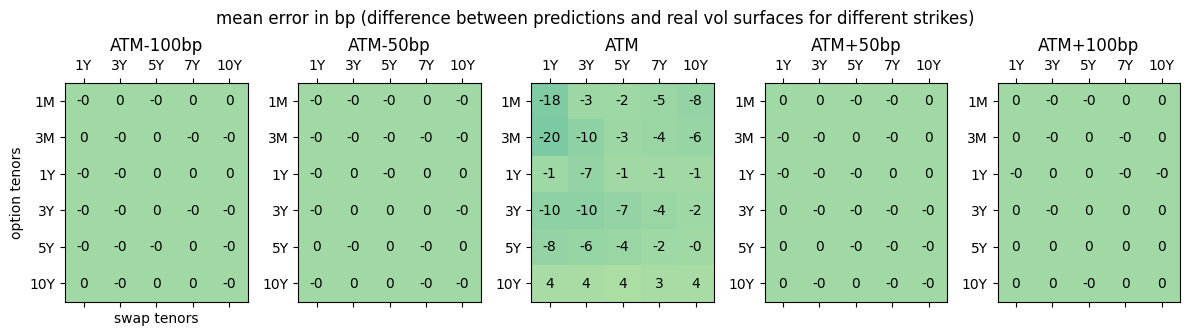

z_real [1.94, -2.15, -0.01]
z_optimal [2.1, -4.18, 11.7]
avg error over all data points 3.16 bp


In [17]:
# z_optimal = [ 2.10023724 -4.18381166 11.70383024]
import numpy as np
from src.visualization.vol.grids_vol_cube_errors import grids_vol_cube_errors

predictions = normalizer.denormalize(vae.decoder.predict(np.array([z_optimal]), verbose=0))  # shape=(1,6,5,7)

for i in range(predictions.shape[1]):
    for j in range(predictions.shape[2]):
        for k in range(predictions.shape[3]):
            if data_test_missed[date_idx, i, j, k] != MISSED_VALUE:
                predictions[0, i, j, k] = data_test[date_idx, i, j, k]

grids_vol_cube_errors(predictions=predictions,
                     data=np.expand_dims(data_test[date_idx],0),
                     x_labels=swap_tenors,
                     y_labels=opt_tenors,
                     strikes=strikes,
                     error_type='mean',  # mse, mean or abs_max
                     )

z_real = vae.encoder.predict(x=np.expand_dims(data_norm_test[date_idx],0), verbose=0)[0][0]
print(f'z_real {[round(x,2) for x in z_real]}')
print(f'z_optimal {[round(x,2) for x in z_optimal]}')
print(f'avg error over all data points {((predictions - np.expand_dims(data_test[date_idx],0))**2).mean()**0.5:.2f} bp')

### Let's assume that all values except ATM vols will be missed for the date with largest vols

##### Create dataset with missed values

In [18]:
# Select index in test dataset for the date with largest vol
if dataset_split_type == 'random_split':
    date_idx = 0   # the date with largest vols that we will investigate     
elif dataset_split_type == 'temporal_split':
    date_idx = 12  # the date with largest vols that we will investigate
# Select the missed strike
missed_strikes = [0, 1, 3, 4]   # 0 is ATM-100bp, 1 is ATM-50bp, 2 is ATM, 3 is ATM+50bp, 4 is ATM+100bp

# Import what value is considered as a missed value
from references.global_parameters import MISSED_VALUE

# Create dataset with missed values
data_test_missed = data_test.copy()
for missed_stk in missed_strikes:
    data_test_missed[date_idx][:, :, missed_stk] = MISSED_VALUE

# Create normalized dataset with missed values
data_norm_test_missed = data_norm_test.copy()
for missed_stk in missed_strikes:
    data_norm_test_missed[date_idx][:, :, missed_stk] = MISSED_VALUE

##### Draw real data grid and real data grid with missed values

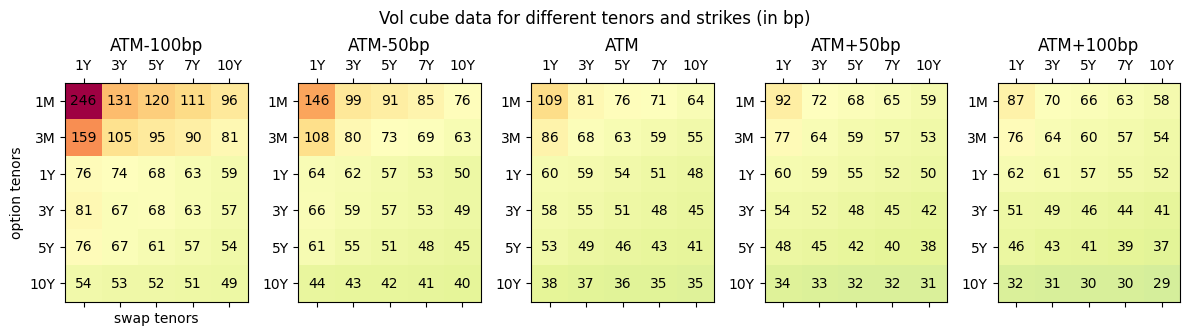

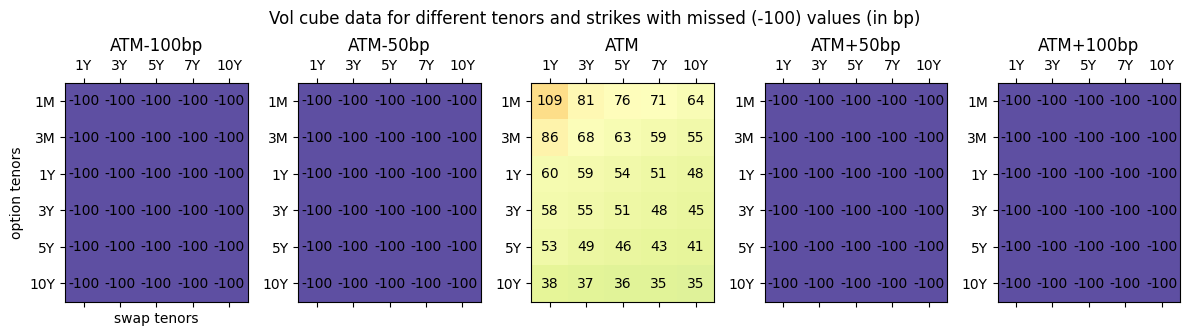

In [19]:
from src.visualization.vol.grids_vol_cube import grids_vol_cube

# Draw real data grid
grids_vol_cube(data=data_test[date_idx],
                x_labels=swap_tenors,
                y_labels=opt_tenors,
                strikes=strikes)

# Draw grid of real data with missed values
grids_vol_cube(data=data_test_missed[date_idx],
                x_labels=swap_tenors,
                y_labels=opt_tenors,
                strikes=strikes)

##### Complete the missed data in vol cube and check errors against real data

In [20]:
from src.utils.vol.find_z_to_complete_vol_cube import find_z_to_complete_vol_cube
z_optimal = find_z_to_complete_vol_cube(vae=vae,
                                        data=data_norm_test_missed[date_idx],
                                        random_attempt_num=5, # number of attempts starting from different random z initial values
                                        random_seed=0,
                                        print_status=True
                                        )

iteration #0
z_initial [5.29215704 1.20047163 2.93621395]
z_optimal [2.18315381 1.12218167 5.55581143]
current mse 0.06428777063086644
best mse 0.06428777063086644
----------------------
iteration #1
z_initial [ 6.7226796   5.60267397 -2.93183364]
z_optimal [ 2.15446869  0.53847967 42.4759592 ]
current mse 0.059525870706325104
best mse 0.059525870706325104
----------------------
iteration #2
z_initial [ 2.85026525 -0.45407162 -0.30965656]
z_optimal [ 2.15446869  0.53847967 42.4759592 ]
current mse 0.06592974652557754
best mse 0.059525870706325104
----------------------
iteration #3
z_initial [1.23179551 0.43213071 4.36282052]
z_optimal [ 2.127688    0.32783768 27.89470541]
current mse 0.0591339529595947
best mse 0.0591339529595947
----------------------
iteration #4
z_initial [2.28311318 0.36502505 1.3315897 ]
z_optimal [ 2.127688    0.32783768 27.89470541]
current mse 0.05927965838195124
best mse 0.0591339529595947
----------------------


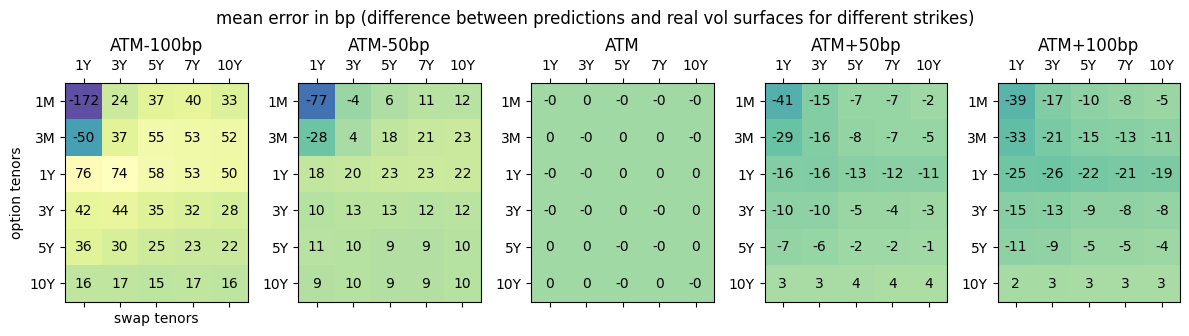

z_real [1.94, -2.15, -0.01]
z_optimal [2.13, 0.33, 27.89]
avg error over all data points 26.17 bp


In [21]:
# z_optimal = 

from src.visualization.vol.grids_vol_cube_errors import grids_vol_cube_errors

predictions = normalizer.denormalize(vae.decoder.predict(np.array([z_optimal]), verbose=0))  # shape=(1,6,5,7)

for i in range(predictions.shape[1]):
    for j in range(predictions.shape[2]):
        for k in range(predictions.shape[3]):
            if data_test_missed[date_idx, i, j, k] != MISSED_VALUE:
                predictions[0, i, j, k] = data_test[date_idx, i, j, k]
                
grids_vol_cube_errors(predictions=predictions,
                     data=np.expand_dims(data_test[date_idx],0),
                     x_labels=swap_tenors,
                     y_labels=opt_tenors,
                     strikes=strikes,
                     error_type='mean'  # mse, mean or abs_max
                     )

z_real = vae.encoder.predict(x=np.expand_dims(data_norm_test[date_idx],0), verbose=0)[0][0]
print(f'z_real {[round(x,2) for x in z_real]}')
print(f'z_optimal {[round(x,2) for x in z_optimal]}')
print(f'avg error over all data points {((predictions - np.expand_dims(data_test[date_idx],0))**2).mean()**0.5:.2f} bp')

In [22]:
print('avg error over all data points', ((predictions - np.expand_dims(data_test[date_idx],0))**2).mean()**0.5)

avg error over all data points 26.16517115398298


# Generate

### Features

Let's generate 20 volatility cubes, make a gif and check whether they have normal levels, short term vols are more volatile, and there is a smile in volatility cubes

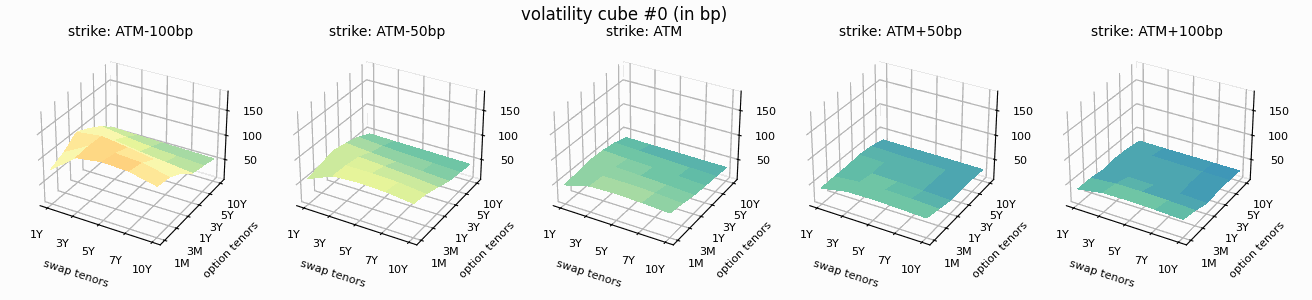

In [23]:
from src.visualization.vol.gif_vol_cube_generate_randomly import gif_vol_cube_generate_randomly

gif_vol_cube_generate_randomly(vae,
                               normalizer,
                               x_labels=swap_tenors,
                               y_labels=opt_tenors,
                               strikes=strikes,
                               delete_pngs=True,
                               z_number=20
                               )

### Consistent with historical volatility data

Let's try to find 1 test dataset vol cube around N newly generated vol cubes

1 test dataset vol cube with the highest vol among all test dataset

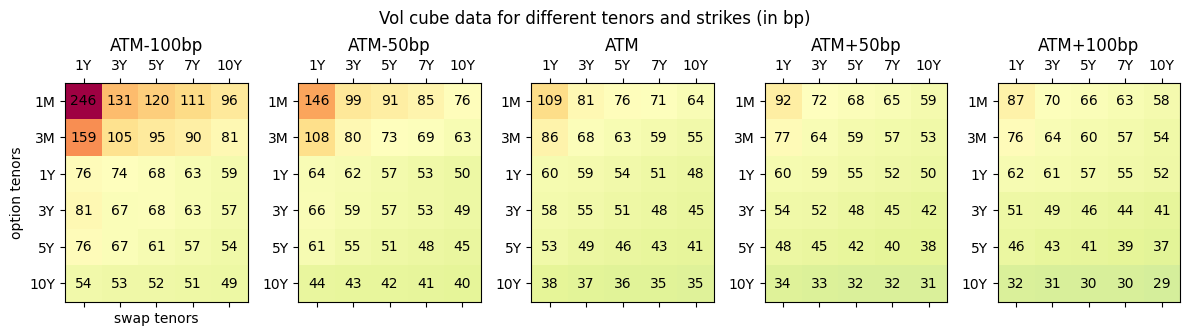

In [24]:
from src.visualization.vol.grids_vol_cube import grids_vol_cube

# Select index in test dataset for the date with largest vol
if dataset_split_type == 'random_split':
    date_idx = 0   # the date with largest vols that we will investigate     
elif dataset_split_type == 'temporal_split':
    date_idx = 12  # the date with largest vols that we will investigate
    
grids_vol_cube(data=data_test[date_idx],
                x_labels=swap_tenors,
                y_labels=opt_tenors,
                strikes=strikes)

Generate N vol cubes

In [25]:
import numpy as np

N = 10_000

latent_space_dim = vae.encoder.predict(x=data_norm_test, verbose=0)[0].shape[1]
mean = np.zeros(latent_space_dim)
cov = np.eye(latent_space_dim)
np.random.seed(0)
z_initial = np.random.multivariate_normal(mean, cov, N)

gen_vol_cubes = normalizer.denormalize(vae.decoder.predict(np.array(z_initial), verbose=0))

Find generated vol cube that fits our test dataset the best way in terms of mse error

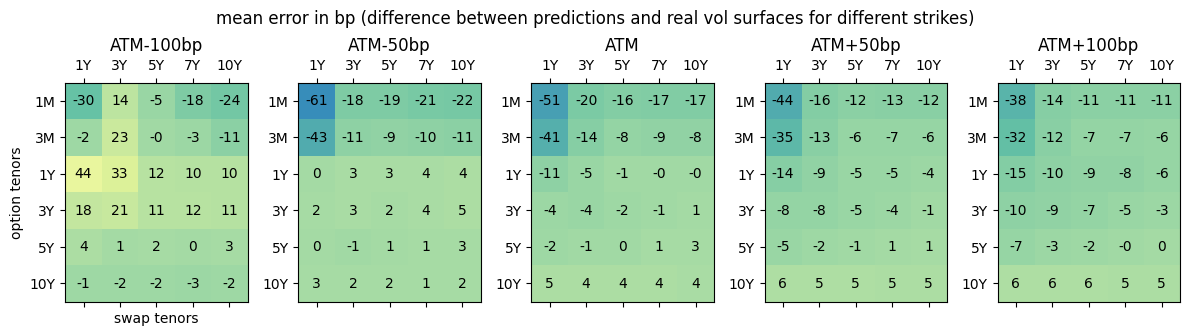

In [26]:
mse_optimal = float('inf')  # largest possible value

for i in range(N):
    diff = data_test[date_idx] - gen_vol_cubes[i]
    mse = (diff**2).mean()
    if mse < mse_optimal:
        id_best = i
        mse_optimal = mse

from src.visualization.vol.grids_vol_cube_errors import grids_vol_cube_errors
grids_vol_cube_errors(predictions=np.expand_dims(gen_vol_cubes[id_best],0),  # not normalized
                     data=np.expand_dims(data_test[date_idx],0),          # not normalized
                     x_labels=swap_tenors,
                     y_labels=opt_tenors,
                     strikes=strikes, 
                     error_type='mean'
                     )

### Robust to small changes (N=1000 takes 5 minutes)

In [27]:
import numpy as np

N = 1_000
SHIFT = 0.01
mean = np.zeros(vae.latent_space_dim)
cov = np.eye(vae.latent_space_dim)
np.random.seed(0)
z_initial_vals = np.random.multivariate_normal(mean, cov, N)

mse_worst = 0
diff_worst = None

for i in range(N):
    # Create vol cube from the random point
    gen_vol_cube_initial = normalizer.denormalize(vae.decoder.predict(np.expand_dims(z_initial_vals[i],0), verbose=0))
    # Create vol cubes moving from the random point in different directions
    for i_dir in range(vae.latent_space_dim):  
        # Plus SHIFT
        z = z_initial_vals[i].copy()
        z[i_dir] += SHIFT
        gen_vol_cube = normalizer.denormalize(vae.decoder.predict(np.expand_dims(z,0), verbose=0))
        diff = gen_vol_cube - gen_vol_cube_initial
        mse = abs(diff).max()
        if mse > mse_worst:
            mse_worst = mse
            diff_worst = diff
        # Minus SHIFT
        z = z_initial_vals[i].copy()
        z[i_dir] -= SHIFT
        gen_vol_cube = normalizer.denormalize(vae.decoder.predict(np.expand_dims(z,0), verbose=0))
        diff = gen_vol_cube - gen_vol_cube_initial
        mse = abs(diff).max()
        if mse > mse_worst:
            mse_worst = mse
            diff_worst = diff

##### The maximum shift in volatility cube over all data points and all test dates

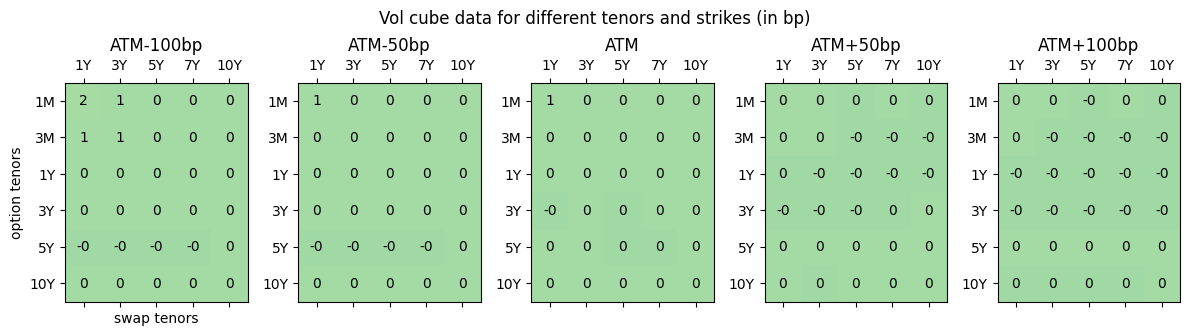

In [28]:
from src.visualization.vol.grids_vol_cube import grids_vol_cube
grids_vol_cube(data=diff_worst[0],
                x_labels=swap_tenors,
                y_labels=opt_tenors,
                strikes=strikes)